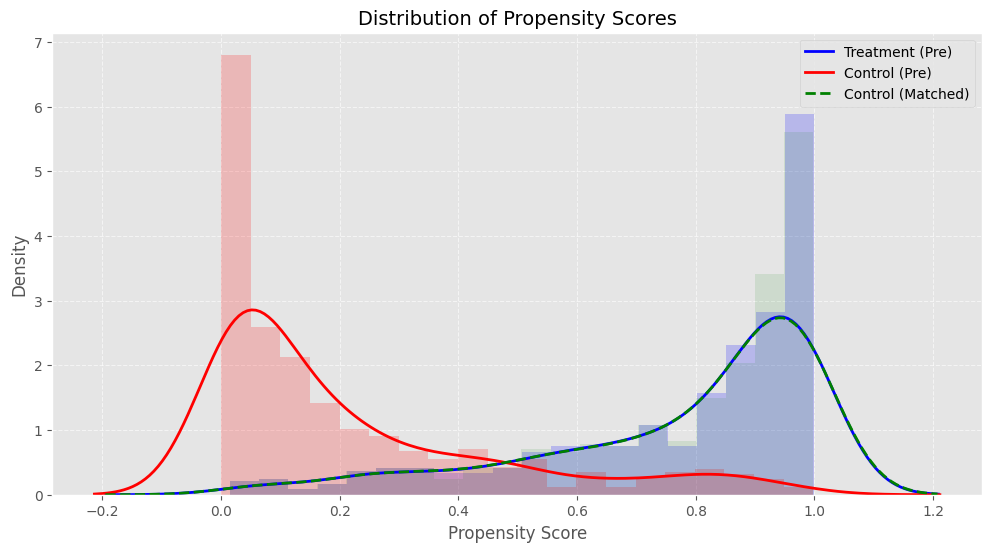

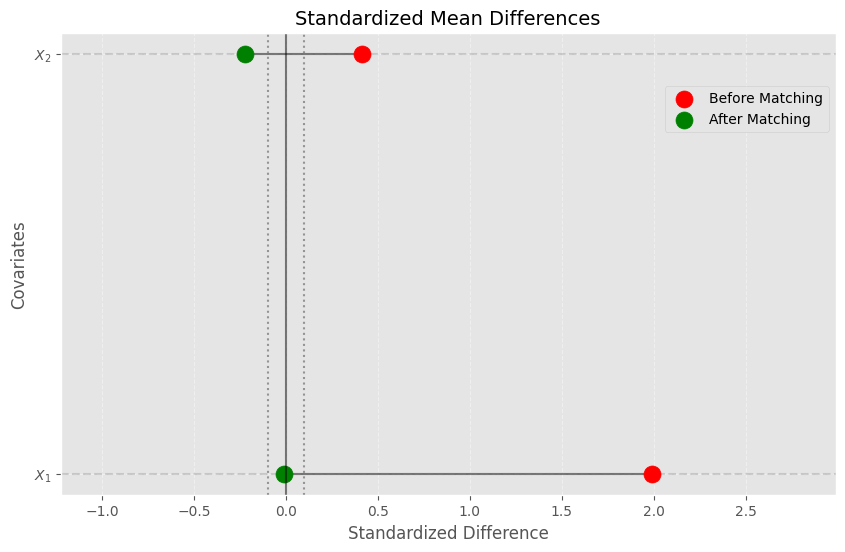


匹配后的样本大小：
处理组原始:                     490
控制组原始:                     510
匹配后的控制组:                   490
总匹配样本数:                    980


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 设置Stata风格的绘图
plt.style.use('ggplot')
sns.set_palette("Set1")

# 生成模拟数据
np.random.seed(42)
n = 1000
data = pd.DataFrame({
    'X1': np.random.normal(0, 1, n),
    'X2': np.random.normal(5, 2, n),
    'T': np.random.choice([0, 1], size=n)
})

# 创建系统性差异
data.loc[data['T'] == 1, 'X1'] += 2
data.loc[data['T'] == 0, 'X2'] -= 1

# 标准化协变量
scaler = StandardScaler()
data[['X1', 'X2']] = scaler.fit_transform(data[['X1', 'X2']])

# 估计倾向得分
model = LogisticRegression()
model.fit(data[['X1', 'X2']], data['T'])
data['ps'] = model.predict_proba(data[['X1', 'X2']])[:, 1]

# 最近邻匹配
nn = NearestNeighbors(n_neighbors=1)
nn.fit(data[data['T'] == 0][['ps']])
distances, indices = nn.kneighbors(data[data['T'] == 1][['ps']])
matched_control = data[data['T'] == 0].iloc[indices.flatten()]

# 计算标准化均值差异（SMD）的函数
def calc_smd(group1, group2):
    mean_diff = group1.mean() - group2.mean()
    pooled_std = np.sqrt((group1.var() + group2.var()) / 2)
    return mean_diff / pooled_std

# 计算匹配前的SMD
smd_x1_pre = calc_smd(data[data['T'] == 1]['X1'], data[data['T'] == 0]['X1'])
smd_x2_pre = calc_smd(data[data['T'] == 1]['X2'], data[data['T'] == 0]['X2'])

# 计算匹配后的SMD
smd_x1_post = calc_smd(data[data['T'] == 1]['X1'], matched_control['X1'])
smd_x2_post = calc_smd(data[data['T'] == 1]['X2'], matched_control['X2'])

# 1. 倾向得分分布（密度图 + 直方图）
plt.figure(figsize=(12, 6))

# 密度图
sns.kdeplot(data[data['T']==1]['ps'], color='b', label='Treatment (Pre)', linewidth=2)
sns.kdeplot(data[data['T']==0]['ps'], color='r', label='Control (Pre)', linewidth=2)
sns.kdeplot(matched_control['ps'], color='g', label='Control (Matched)', linewidth=2, linestyle='--')

# 直方图叠加（透明）
plt.hist(data[data['T']==1]['ps'], bins=20, color='b', alpha=0.2, density=True)
plt.hist(data[data['T']==0]['ps'], bins=20, color='r', alpha=0.2, density=True)
plt.hist(matched_control['ps'], bins=20, color='g', alpha=0.1, density=True)

plt.title('Distribution of Propensity Scores', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('./dps.png', dpi=300)
plt.show()

# 2. Love图（带阈值）
plt.figure(figsize=(10, 6))
variables = ['$X_1$', '$X_2$']
smd_pre = [smd_x1_pre, smd_x2_pre]
smd_post = [smd_x1_post, smd_x2_post]

_range = smd_pre + smd_post

# 为每个变量添加水平线
plt.hlines(y=variables, xmin=np.min(_range) - 1, xmax=np.max(_range) + 1, color='gray', linestyles='dashed', alpha=0.3)

# 绘制SMD点和连接线
for i, var in enumerate(variables):
    plt.plot([smd_pre[i], smd_post[i]], [var, var], color='k', alpha=0.5, zorder=1)
plt.scatter(smd_pre, variables, color='r', s=150, label='Before Matching', zorder=2)
plt.scatter(smd_post, variables, color='g', s=150, label='After Matching', zorder=2)

# 阈值线和样式
plt.axvline(x=0, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=0.1, color='gray', linestyle=':', alpha=0.8)
plt.axvline(x=-0.1, color='gray', linestyle=':', alpha=0.8)

plt.xlim(np.min(_range) - 1, np.max(_range) + 1)
plt.title('Standardized Mean Differences', fontsize=14)
plt.xlabel('Standardized Difference', fontsize=12)
plt.ylabel('Covariates', fontsize=12)
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(1, 0.9))
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig('./smd.png', dpi=300)
plt.show()

# 打印样本大小（匹配前后的对比）
original_treated = data[data['T']==1].shape[0]
original_control = data[data['T']==0].shape[0]
matched_control_count = matched_control.shape[0]

print("\n匹配后的样本大小：")
print("="*40)
print(f"{'处理组原始:':<20}{original_treated:>10}")
print(f"{'控制组原始:':<20}{original_control:>10}")
print(f"{'匹配后的控制组:':<20}{matched_control_count:>10}")
print(f"{'总匹配样本数:':<20}{(original_treated + matched_control_count):>10}")
print("="*40)
